## Introduction to Python Steering
The following is a tour of the basic layout of CRPropa 3, showing how to setup and run a 1D simulation of the extragalactic propagation of UHECR protons from a Python shell.

### Simulation setup
We start with a ```ModuleList```, which is a container for simulation modules, and represents the simulation.

The first module in a simulation should be a propagation module, which will move the cosmic rays. In a 1D simulation magnetic deflections of charged particles are not considered, thus we can use the ```SimplePropagation``` module for rectalinear propagation.

Next we add modules for photo-pion and electron-pair production with the cosmic microwave background and a module for neutron and nuclear decay. Finally we add a minimum energy requirement: Cosmic rays are stopped once they reach the minimum energy.
In general the order of modules doesn't matter much for sufficiently small propagation steps. For good practice, we recommend the order: Propagator --> Interactions -> Break conditions -> Observer / Output.

**Please note** that all input, output and internal calculations are done using SI-units to enforce expressive statements such as ```E = 1 * EeV``` or ```D = 100 * Mpc```.

In [1]:
from crpropa import *

# simulation: a sequence of simulation modules
sim = ModuleList()

# add propagator for rectalinear propagation
sim.add( SimplePropagation() )

# add interaction modules
sim.add( PhotoPionProduction(CMB()) )
sim.add( ElectronPairProduction(CMB()) )
sim.add( NuclearDecay() )
sim.add( MinimumEnergy( 1 * EeV) )

### Propagating a single particle

The simulation can now be used to propagate a cosmic ray, which is called candidate. We create a 100 EeV proton and propagate it using the simulation. The propagation stops when the energy drops below the minimum energy requirement that was specified. The possible propagation distances are rather long since we are neglecting cosmology in this example.

In [2]:
cosmicray = Candidate(nucleusId(1,1), 200 * EeV, Vector3d(100 * Mpc, 0, 0))

sim.run(cosmicray)
print(cosmicray)
print('Propagated distance', cosmicray.getTrajectoryLength() / Mpc, 'Mpc')

CosmicRay at z = 0
  source:  Particle 1000010010, E = 200 EeV, x = 100 0 0 Mpc, p = -1 0 0
  current: Particle 1000010010, E = 0.975343 EeV, x = -13875.4 0 0 Mpc, p = -1 0 0
Propagated distance 13975.411990394969 Mpc


### Defining an observer

To define an observer within the simulation we create an ```Observer``` object.
The convention of 1D simulations is that cosmic rays, starting from positive coordinates, propagate in the negative direction until they reach the observer at 0. Only the x-coordinate is used in the three-vectors that represent position and momentum.

In [3]:
# add an observer
obs = Observer()
obs.add( ObserverPoint() )  # observer at x = 0
sim.add(obs)
print(obs)

Observer
    ObserverPoint: observer at x = 0
    Flag: '' -> ''
    MakeInactive: yes



### Defining the output file 
We want to save the propagated cosmic rays to an output file.
Plain text output is provided by the TextOutput module.  
For the type of information being stored we can use one of five presets: Event1D, Event3D, Trajectory1D, Trajectory3D and Everything.  
We can also fine tune with ```enable(XXXColumn)``` and ```disable(XXXColumn)```

In [4]:
# trajectory output
output1 = TextOutput('trajectories.txt', Output.Trajectory1D)
#sim.add(output1)  # generates a lot of output

#output1.disable(Output.RedshiftColumn)  # don't save the current redshift
#output1.disableAll()  # disable everything to start from scratch
#output1.enable(Output.CurrentEnergyColumn)  # current energy
#output1.enable(Output.CurrentIdColumn)      # current particle type
# ...


If in the example above ```output1``` is added to the module list, it is called on every propagation step to write out the cosmic ray information. 
To only save cosmic rays that reach our observer, we add an output to the observer that we previously defined.
This time we are satisfied with the output type Event1D.

In [8]:
# event output
output2 = TextOutput('events.txt', Output.Event1D)
obs.onDetection(output2)

#sim.run(cosmicray)
#output2.close()

Similary, the output could be linked to the ```MinimumEnergy``` module to save those cosmic rays that fall below the minimum energy, and so on.  
**Note:** If we want to use the CRPropa output file from within the same  script that runs the simulation, the output module should be explicitly closed after the simulation run in order to get all events flushed to the file.

### Defining the source
To avoid setting each individual cosmic ray by hand we define a cosmic ray source.
The source is located at a distance of 100 Mpc and accelerates protons to a power law spectrum and energies between 1 - 200 EeV.

In [9]:
# cosmic ray source
source = Source()
source.add( SourcePosition(100 * Mpc) )
source.add( SourceParticleType(nucleusId(1, 1)) )
source.add( SourcePowerLawSpectrum(1 * EeV, 200 * EeV, -1) )
print(source)

Cosmic ray source
    SourcePosition: 100 0 0 Mpc
    SourceParticleType: 1000010010
    SourcePowerLawSpectrum: Random energy E = 1 - 200 EeV, dN/dE ~ E^-1



### Running the simulation

Finally we run the simulation to inject and propagate 10000 cosmic rays. An optional progress bar can show the progress of the simulation.

In [10]:
sim.setShowProgress(True)  # switch on the progress bar
sim.run(source, 10000)

### (Optional) Plotting

This is not part of CRPropa, but since we're at it we can plot the energy spectrum of detected particles to observe the GZK suppression.
The plotting is done here using matplotlib, but of course you can use whatever plotting tool you prefer.  


Number of events 10000


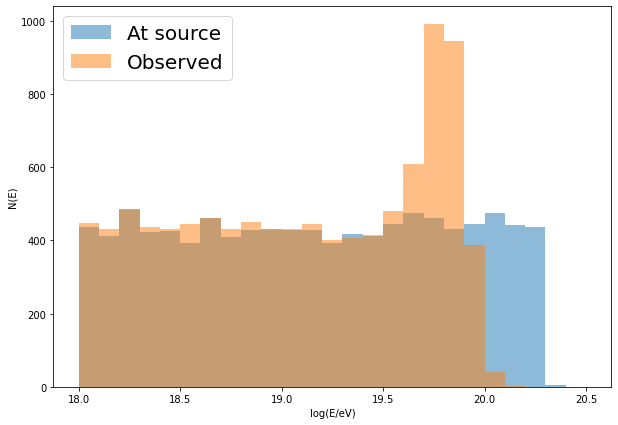

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

output2.close()  # close output file before loading
data = np.genfromtxt('events.txt', names=True)
print('Number of events', len(data))

logE0 = np.log10(data['E0']) + 18
logE  = np.log10(data['E']) + 18

plt.figure(figsize=(10, 7))
h1 = plt.hist(logE0, bins=25, range=(18, 20.5), histtype='stepfilled', alpha=0.5, label='At source')
h2 = plt.hist(logE,  bins=25, range=(18, 20.5), histtype='stepfilled', alpha=0.5, label='Observed')
plt.xlabel('log(E/eV)')
plt.ylabel('N(E)')
plt.legend(loc = 'upper left', fontsize=20)
